In [1]:
!pip install keras
!pip install sklearn
!pip install -U -q segmentation-models
!pip install -q tensorflow==2.1
!pip install -q keras==2.3.1
!pip install -q tensorflow-estimator==2.1.

     |████████████████████████████████| 1.3 MB 4.7 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=c3610e54860757b15e6cd192939c7298abfb26ddfd344925dea8f42f80a31f20
  Stored in directory: /home/jovyan/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [4]:
#Librerias de os
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ["SM_FRAMEWORK"] = "tf.keras"

#Librerias para el manejo de datos
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Librerias para la Regresion Logística
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Librerias para construir el Clasificador Binario
import keras
from keras.models import Model, Sequential
from keras.layers import Dense, Activation
import keras.backend as K
from keras import optimizers

print("Librerias importadas correctamente!!!")

/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method

Librerias importadas correctamente!!!


In [5]:
header = ["Varianza", "Oblicuidad", "Curtosis", "Entropía", "Clase"]
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', names=header)
df.head(500)

,Varianza,Oblicuidad,Curtosis,Entropía,Clase
0,3.621600,8.6661,-2.80730,-0.44699,0
1,4.545900,8.1674,-2.45860,-1.46210,0
2,3.866000,-2.6383,1.92420,0.10645,0
3,3.456600,9.5228,-4.01120,-3.59440,0
4,0.329240,-4.4552,4.57180,-0.98880,0
...,...,...,...,...,...
495,-0.126240,10.3216,-3.71210,-6.11850,0
496,3.375600,-4.0951,4.36700,1.06980,0
497,-0.048008,-1.6037,8.47560,0.75558,0
498,0.570600,-0.0248,1.24210,-0.56210,0


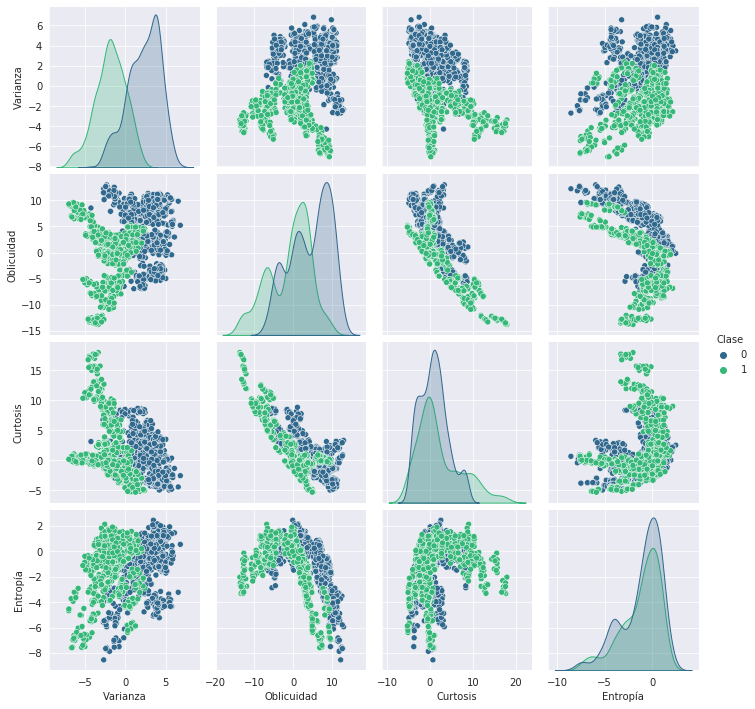

Estadisticas del dataset: 
           Varianza   Oblicuidad     Curtosis     Entropía        Clase
count  1372.000000  1372.000000  1372.000000  1372.000000  1372.000000
mean      0.433735     1.922353     1.397627    -1.191657     0.444606
std       2.842763     5.869047     4.310030     2.101013     0.497103
min      -7.042100   -13.773100    -5.286100    -8.548200     0.000000
25%      -1.773000    -1.708200    -1.574975    -2.413450     0.000000
50%       0.496180     2.319650     0.616630    -0.586650     0.000000
75%       2.821475     6.814625     3.179250     0.394810     1.000000
max       6.824800    12.951600    17.927400     2.449500     1.000000
Observaciones por clase: 
 0    762
1    610
Name: Clase, dtype: int64


In [6]:
# Graficando información del dataset

import seaborn as sns
sns.set_style('darkgrid')
sns.pairplot(data=df, hue='Clase', palette = 'viridis')

plt.show()

print("Estadisticas del dataset: \n", df.describe())

print("Observaciones por clase: \n", df['Clase'].value_counts())

In [7]:
cols = df.columns[0:4]
X = np.array(df[cols].values)
Xs = preprocessing.scale(X)
y = np.array(df['Clase'])

ntr = 1000
nts = 372
Xtr, Xts, ytr, yts = train_test_split(X,y,train_size=ntr, test_size=nts,shuffle=True)

In [8]:
#Escalando el entrenamiento y matrices para pruebas
xmean = np.mean(Xtr, axis = 0)
xstd = np.std(Xtr, axis = 0)
Xtr_scale = (Xtr - xmean[None,:])/xstd[None, :]
Xts_scale = (Xts - xmean[None,:])/xstd[None, :]

In [9]:
#Construyendo el modelo
nin = Xtr.shape[1]
nout = np.max(ytr) + 1
nh = 256
model = Sequential()
model.add(Dense(nh, input_shape=(nin, ), activation='sigmoid', name= 'hidden'))
model.add(Dense(nout, activation = 'softmax', name = 'output'))

In [10]:
#Resumen del modelo
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden (Dense)               (None, 256)               1280      
_________________________________________________________________
output (Dense)               (None, 2)                 514       
Total params: 1,794
Trainable params: 1,794
Non-trainable params: 0
_________________________________________________________________


In [44]:
#Ajuste de la rapidez de aprendizaje
opt = optimizers.Adam(lr = 0.001)
model.compile(optimizer=opt, loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [48]:
#Entrenar modelo
batch_size = 100
history=model.fit(Xtr_scale, ytr, epochs = 10, batch_size=batch_size, validation_data=(Xts_scale, yts))

Train on 1000 samples, validate on 372 samples
Epoch 1/10
1000/1000 [==============================] - 0s 23us/step - loss: 0.0237 - accuracy: 0.9920 - val_loss: 0.0302 - val_accuracy: 0.9866
Epoch 2/10
1000/1000 [==============================] - 0s 20us/step - loss: 0.0232 - accuracy: 0.9920 - val_loss: 0.0301 - val_accuracy: 0.9866
Epoch 3/10
1000/1000 [==============================] - 0s 24us/step - loss: 0.0234 - accuracy: 0.9920 - val_loss: 0.0301 - val_accuracy: 0.9866
Epoch 4/10
1000/1000 [==============================] - 0s 74us/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 0.0297 - val_accuracy: 0.9866
Epoch 5/10
1000/1000 [==============================] - 0s 26us/step - loss: 0.0235 - accuracy: 0.9920 - val_loss: 0.0296 - val_accuracy: 0.9866
Epoch 6/10
1000/1000 [==============================] - 0s 66us/step - loss: 0.0231 - accuracy: 0.9920 - val_loss: 0.0294 - val_accuracy: 0.9866
Epoch 7/10
1000/1000 [==============================] - 0s 21us/step - loss: 0.0229

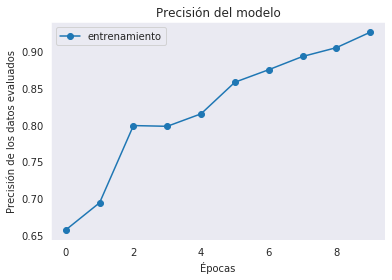

In [17]:
#Gráfico de precisión del clasificador 

plt.plot(history.history['accuracy'], 'o-')
plt.title('Precisión del modelo')
plt.ylabel('Precisión de los datos evaluados')
plt.xlabel('Épocas')
plt.legend(['entrenamiento'], loc='upper left')
plt.grid()
plt.show()

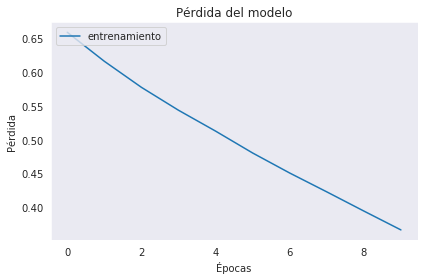

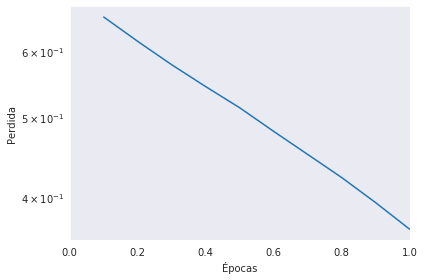

In [18]:
#Gráfico de perdida

plt.plot(history.history['loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['entrenamiento'], loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

nsteps = len(history.history['loss'])
ntr = Xtr.shape[0]
epochs = np.arange(1, nsteps + 1)*batch_size/ntr
plt.semilogy(epochs, history.history['loss'])
plt.xlabel('Épocas')
plt.ylabel('Perdida')
plt.grid()
plt.xlim([0, np.max(epochs)])
plt.tight_layout()

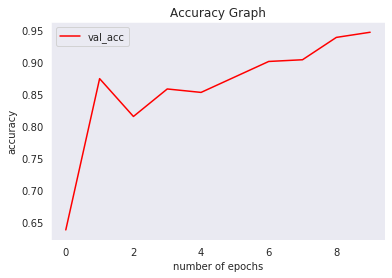

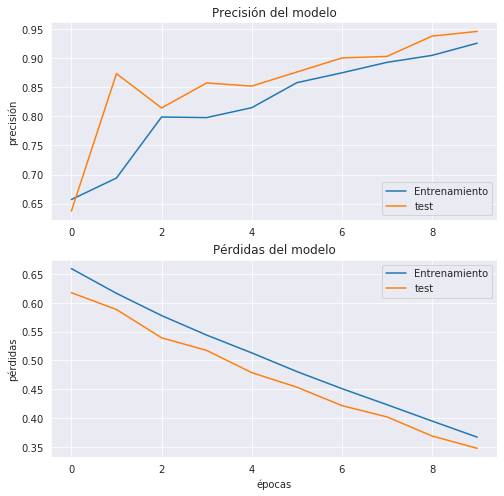

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(10)
#grafica de accuracy vs epocas
plt.plot(val_acc,color="r",label="val_acc") 
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

#grafica de accuracy vs epocas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='test')
plt.legend(loc='lower right')
plt.ylabel("precisión")
plt.title('Precisión del modelo')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='test')
plt.legend(loc='upper right')
plt.xlabel("épocas")
plt.ylabel("pérdidas")
plt.title('Pérdidas del modelo')
plt.show()

In [49]:
#Modelo ajustado
model = Sequential()
model.add(Dense(nh, input_shape=(nin, ), activation='sigmoid', name= 'hidden'))
model.add(Dense(nout, activation = 'softmax', name = 'output'))

#Ajuste de la rapidez de aprendizaje
opt = optimizers.Adam(lr = 0.01)
model.compile(optimizer=opt, loss ='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:
batch_size = 100
history= model.fit(Xtr_scale, ytr, epochs = 10, batch_size=batch_size, validation_data=(Xts_scale, yts))

Train on 1000 samples, validate on 372 samples
Epoch 1/10
1000/1000 [==============================] - 0s 20us/step - loss: 4.9163e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 2/10
1000/1000 [==============================] - 0s 21us/step - loss: 4.8512e-04 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 3/10
1000/1000 [==============================] - 0s 20us/step - loss: 4.9354e-04 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 4/10
1000/1000 [==============================] - 0s 72us/step - loss: 4.7376e-04 - accuracy: 1.0000 - val_loss: 0.0012 - val_accuracy: 1.0000
Epoch 5/10
1000/1000 [==============================] - 0s 19us/step - loss: 4.7177e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/10
1000/1000 [==============================] - 0s 74us/step - loss: 4.7230e-04 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 7/10
1000/1000 [==============================] - 0s 

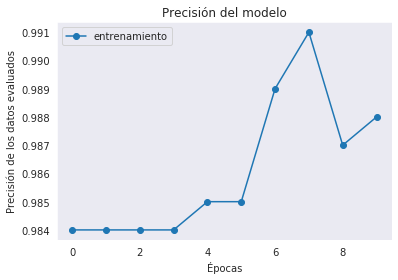

In [32]:
#Gráfico de precisión del clasificador 

plt.plot(history.history['accuracy'], 'o-')
plt.title('Precisión del modelo')
plt.ylabel('Precisión de los datos evaluados')
plt.xlabel('Épocas')
plt.legend(['entrenamiento'], loc='upper left')
plt.grid()
plt.show()

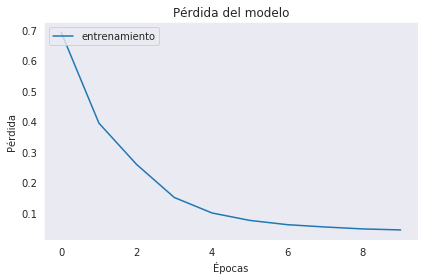

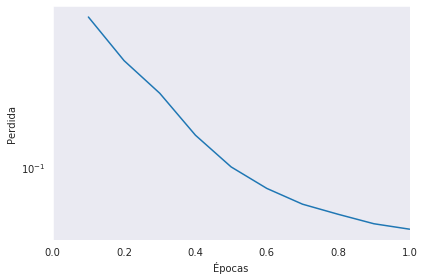

In [16]:
#Gráfico de perdida

plt.plot(history.history['loss'])
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['entrenamiento'], loc='upper left')
plt.tight_layout()
plt.grid()
plt.show()

nsteps = len(history.history['loss'])
ntr = Xtr.shape[0]
epochs = np.arange(1, nsteps + 1)*batch_size/ntr
plt.semilogy(epochs, history.history['loss'])
plt.xlabel('Épocas')
plt.ylabel('Perdida')
plt.grid()
plt.xlim([0, np.max(epochs)])
plt.tight_layout()

#Resultados: esta función de pérdida converge más rápido que la anterior porque la tasa de aprendizaje es mayor
##Sin embargo, la precisión de este aprendizaje es más alta que línea de la Regresión Logística

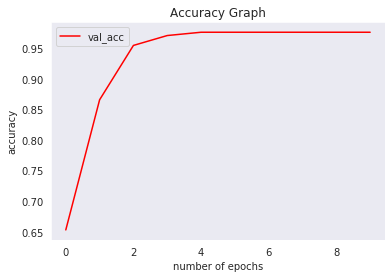

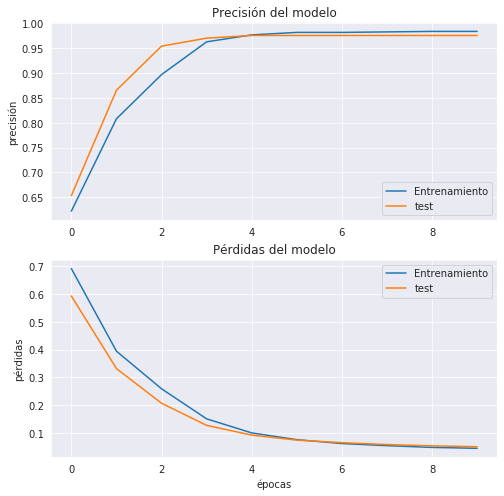

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range= range(10)
#grafica de accuracy vs epocas
plt.plot(val_acc,color="r",label="val_acc") 
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

#grafica de accuracy vs epocas
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Entrenamiento')
plt.plot(epochs_range, val_acc, label='test')
plt.legend(loc='lower right')
plt.ylabel("precisión")
plt.title('Precisión del modelo')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Entrenamiento')
plt.plot(epochs_range, val_loss, label='test')
plt.legend(loc='upper right')
plt.xlabel("épocas")
plt.ylabel("pérdidas")
plt.title('Pérdidas del modelo')
plt.show()

In [18]:
#Matriz de confusión
y_predict = model.predict_classes(Xts)
from sklearn.metrics import confusion_matrix, classification_report
confMatrix = confusion_matrix(yts, y_predict)
print(confMatrix)

[[205   0]
 [ 74  93]]


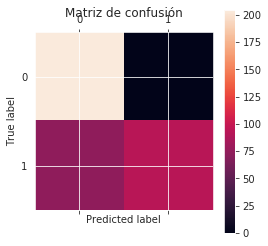

In [19]:
plt.matshow(confMatrix)
plt.title('Matriz de confusión')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

#La matriz de confusión indica que hubo 227 predicciones verdaderas negativas,
# 180 verdaderas positivas, 0 falsas negativas y
# 5 falsas positivas

In [20]:
#Comparación optima utilzando el clasificador RandomForest
from sklearn.ensemble import RandomForestClassifier
rc= RandomForestClassifier()
rc.fit(Xtr, ytr)

y_predict = rc.predict(Xts)
print(classification_report(yts, y_predict))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       205
           1       0.99      0.98      0.99       167

    accuracy                           0.99       372
   macro avg       0.99      0.99      0.99       372
weighted avg       0.99      0.99      0.99       372



/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/decomposition/online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps
/srv/conda/envs/notebook/lib/python3.7/site-packages/sklearn/ensemble/gradient_boosting.py:32: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from ._gradient_boosting import pred

In [21]:
from sklearn.metrics import accuracy_score
print("Precisión del modelo : %.5f" % accuracy_score(yts, y_predict))

Precisión del modelo : 0.98925


Librerias cargadas correctamente


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for f

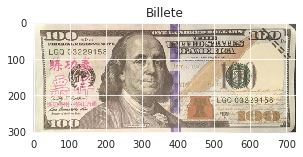

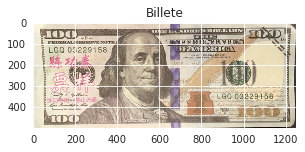

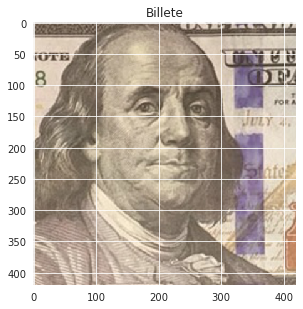

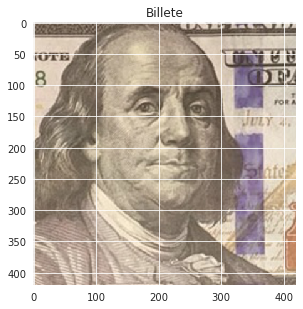

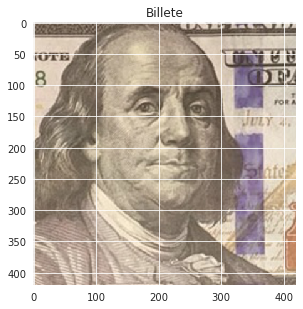

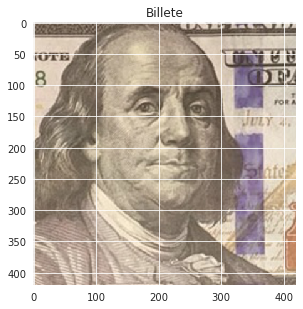

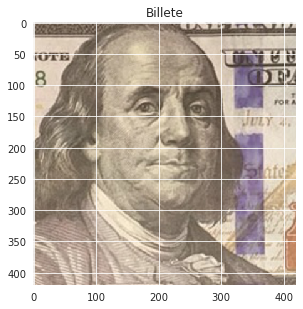

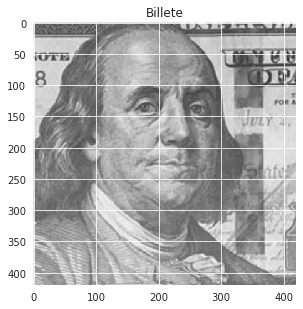

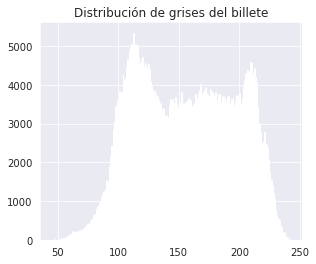

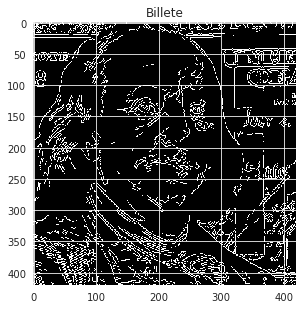

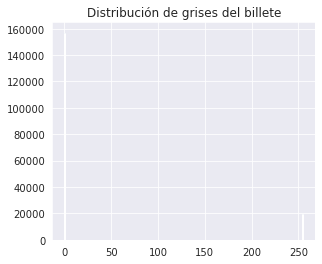

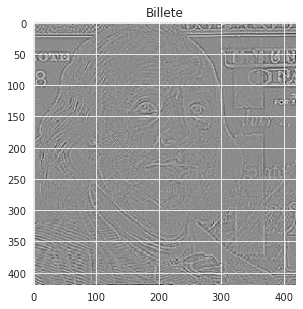

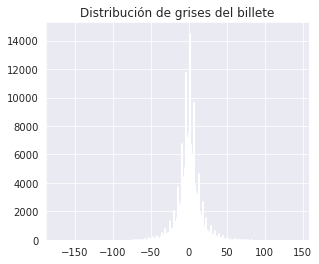

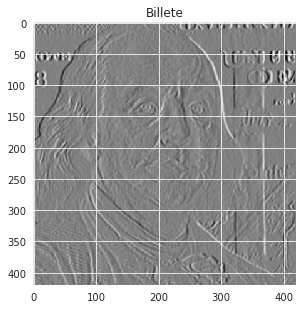

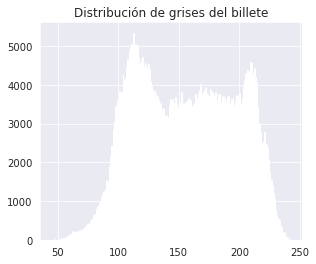

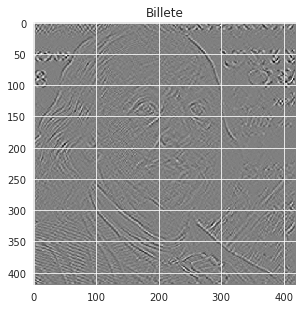

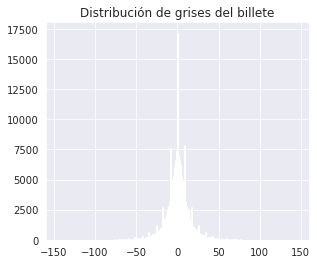

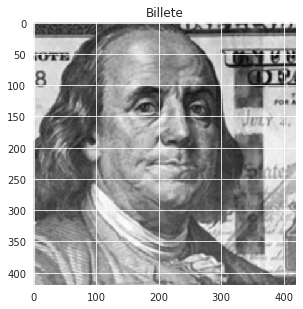

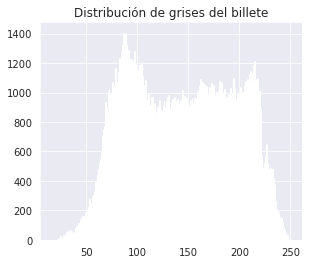

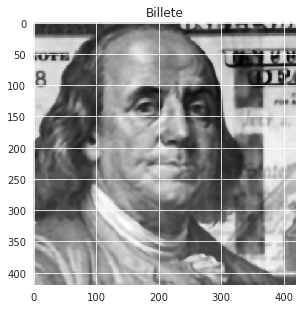

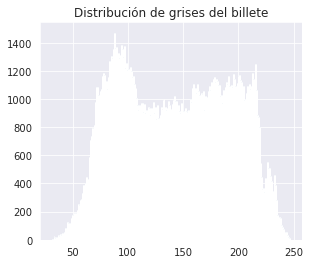

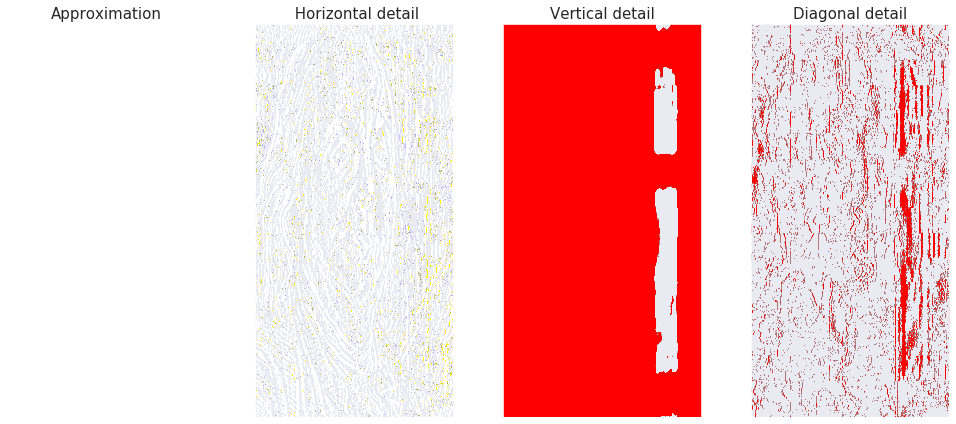

[0.295957999557471, 0.013569331289915117, 1.3663497951210548, nan]
[31.4239202889156, -0.009498221214974555, 0.5998566198184189, 0]


In [119]:
#Extrayendo los valores del billete
%run PreprocesamientoBilletes.ipynb
billete_crudo=obtenerFeatures('images/fake_dollar_note.jpg')
print(billete_crudo)

In [121]:
# Predicción de una nuevo billete pre-procesado
le = LabelEncoder()
y = le.fit_transform(y)

#Definir un nueva entrada de datos
#billete_crudo=[-0.69745,-1.7672,-0.34474,-0.12372]

nuevo_billete= np.array([billete_crudo],dtype=np.float32)

#Realizar la prediccion 
yhat= model.predict_classes(nuevo_billete)

print("Predicción\n")

if yhat[0]==1:
    print("Billete autentico: clase {}".format(int(yhat[0])))
else:
    print("Billete falso: clase {}".format(int(yhat[0])))


Predicción

Billete falso: clase 0
